    Ben Christensen
    Math 323
    1/18/18

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import BarycentricInterpolator
from scipy import linalg as la

In [6]:
def lagrange(xint, yint, points):
    """Find an interpolating polynomial of lowest degree through the points
    (xint, yint) using the Lagrange method and evaluate that polynomial at
    the specified points.

    Parameters:
        xint ((n,) ndarray): x values to be interpolated.
        yint ((n,) ndarray): y values to be interpolated.
        points((m,) ndarray): x values at which to evaluate the polynomial.

    Returns:
        ((m,) ndarray): The value of the polynomial at the specified points.
    """
    n = len(xint)
    m = len(points)
    L = []
    #Compute the denominator of each L_j
    for j in range(n):
        denom = np.prod([xint[j] - xint[k] for k in range(n) if k != j])
        numer = np.ones_like(points)
    #Update the numerator of each L_j
        for k in range(n):
            if k != j:
                numer *= points - xint[k]
        L.append(numer * yint[j] / denom)
    #Return the polynomial evaluated at the points
    return np.array([sum([L[i][j] for i in range(n)]) for j in range(m)])




# Problems 2 and 3
class Barycentric:
    """Class for performing Barycentric Lagrange interpolation.

    Attributes:
        w ((n,) ndarray): Array of Barycentric weights.
        n (int): Number of interpolation points.
        x ((n,) ndarray): x values of interpolating points.
        y ((n,) ndarray): y values of interpolating points.
    """

    def __init__(self, xint, yint):
        """Calculate the Barycentric weights using initial interpolating points.

        Parameters:
            xint ((n,) ndarray): x values of interpolating points.
            yint ((n,) ndarray): y values of interpolating points.
        """
        n = len(xint)
        w = np.ones(n)
        C = (np.max(xint) - np.min(xint)) / 4
        #Randomize to avoid overflow in arithmetic
        shuffle = np.random.permutation(n-1)
        for j in range(n):
            temp = (xint[j] - np.delete(xint, j)) / C
            temp = temp[shuffle]
            w[j] /= np.product(temp)
        #Store the x values, y values, and weights
        self.xint = xint
        self.yint = yint
        self.weights = w

    def __call__(self, points):
        """Using the calcuated Barycentric weights, evaluate the interpolating polynomial
        at points.

        Parameters:
            points ((m,) ndarray): Array of points at which to evaluate the polynomial.

        Returns:
            ((m,) ndarray): Array of values where the polynomial has been computed.
        """
        numer = 0
        denom = 0
        #Use numpy broadcasting to evaluate the interpolating polynomial at m points
        for j in range(len(self.xint)):
            numer += self.weights[j] * self.yint[j] * (points - self.xint[j])** -1
            denom += self.weights[j] * (points - self.xint[j])** -1

        return numer/denom


    # Problem 3
    def add_weights(self, xint, yint):
        """Update the existing Barycentric weights using newly given interpolating points
        and create new weights equal to the number of new points.

        Parameters:
            xint ((m,) ndarray): x values of new interpolating points.
            yint ((m,) ndarray): y values of new interpolating points.
        """
        #Update x values and y values
        m = len(xint)
        new_w = np.ones(m)
        C = (np.max(self.xint) - np.min(self.xint)) / 4
        shuffle = np.random.permutation(m-1)
        self.xint = np.append(self.xint, xint)
        self.yint = np.append(self.yint, yint)
        #Update the existing weights using the original algorithm
        for i, x_i in enumerate(xint):
            self.weights = self.weights / (self.xint[m:] - x_i)
            temp = (xint[i] - np.delete(xint, i)) / C
            temp = temp[shuffle]
            new_w[i] /= np.product(temp)
        #Add the new weights
        self.weights = np.append(self.weights, new_w)


# Problem 4
def prob4():
    """For n = 2^2, 2^3, ..., 2^8, calculate the error of intepolating Runge's
    function on [-1,1] with n points using SciPy's BarycentricInterpolator
    class, once with equally spaced points and once with the Chebyshev
    extremal points. Plot the absolute error of the interpolation with each
    method on a log-log plot.
    """
    domain = np.linspace(-1, 1, 400)
    f = lambda x: 1/(1+25*x**2)
    Runge = f(domain)
    err1 = []
    err2 = []
    N = [2**i for i in range(2, 9)]
    for n in N:
        sample = np.linspace(-1, 1, n)
        approx = BarycentricInterpolator(sample, f(sample))
        err1.append(la.norm(Runge - approx(domain), ord=np.inf))
        #Sample at the Chebyshev extremal points
        sample = np.array([1/2 * (2*np.cos(j*np.pi/n)) for j in range(n+1)])
        approx = BarycentricInterpolator(sample, f(sample))
        err2.append(la.norm(Runge - approx(domain), ord=np.inf))
    #Plot the errors of the interpolator at equally spaced points and at Cheb. extrema
    plt.loglog(N, err1, basex=2, basey=2, label="Equally spaced")
    plt.loglog(N, err2, basex=2, basey=2, label="Cheb. extrema")
    plt.legend(loc = "upper left")
    plt.show()


# Problem 5
def chebyshev_coeffs(f, n):
    """Obtain the Chebyshev coefficients of a polynomial that interpolates
    the function f at n points.

    Parameters:
        f (function): Function to be interpolated.
        n (int): Number of points at which to interpolate.

    Returns:
        coeffs ((n+1,) ndarray): Chebyshev coefficients for the interpolating polynomial.
    """
    #Calculate y_0, ..., y_2n-1 Chebyshev extremal points
    points = [np.cos(j*np.pi/n) for j in range(n+1)]
    duplicates = points[-2:0:-1]
    points.extend(duplicates)
    #Using the algorithm find the Chebyshev coefficients
    a = np.real(np.fft.fft(f(np.array(points))) / (2*n))[:n+1]
    mask = 2 * np.ones_like(a)
    mask[0], mask[n] = 1, 1
    return (a*mask)


# Problem 6
def prob6(n):
    """Interpolate the air quality data found in airdata.npy using
    Barycentric Lagrange interpolation. Plot the original data and the
    interpolating polynomial.

    Parameters:
        n (int): Number of interpolating points to use.
    """
    #Find the closest match in non-continuous data for Chebyshev extrema
    data = np.load("/Users/benchristensen/Desktop/ACME Python Labs/Volume2-Student-Materials/PolynomialInterpolation/airdata.npy")
    fx = lambda a, b, n: .5*(a+b + (b-a) * np.cos(np.arange(n+1) * np.pi / n))
    a, b = 0, 366 - 1/24
    domain = np.linspace(0, b, 8784)
    points = fx(a, b, n)
    temp = np.abs(points - domain.reshape(8784, 1))
    temp2 = np.argmin(temp, axis=0)
    poly = BarycentricInterpolator(domain[temp2], data[temp2])
    #plot the data against the interpolating polynomial
    plt.subplot(121)
    plt.plot(domain, data)
    plt.title("Data")
    plt.subplot(122)
    plt.plot(domain, poly(domain))
    plt.title("Interpolating Polynomial")
    plt.show()





/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in reciprocal
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in reciprocal
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in add
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in add


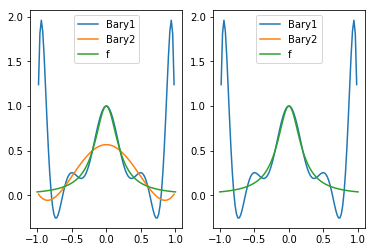

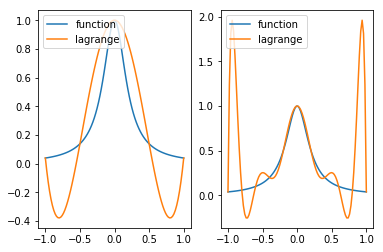

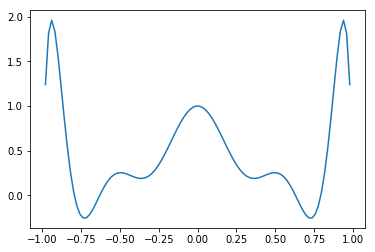

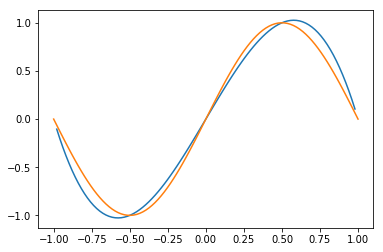

In [7]:
x = np.linspace(-1,1,100)
f = lambda x: 1/(1+25*x**2)
xint1 = np.linspace(-1,1,11)
xint2 = np.linspace(-1,1,6)
xint3 = np.linspace(-0.8,0.8,5)
#bary objects
bary1 = Barycentric(xint1,f(xint1))
bary2 = Barycentric(xint2,f(xint2))
#first plot
plt.subplot(121)
plt.plot(x,bary1(x),label="Bary1")
plt.plot(x,bary2(x),label="Bary2")
plt.plot(x,f(x),label="f")
plt.legend()
#add weights
bary2.add_weights(xint3,f(xint3))
#second plot
plt.subplot(122)
plt.plot(x,bary1(x),label="Bary1")
plt.plot(x,bary2(x),label="Bary2")
plt.plot(x,f(x),label="f")
plt.legend()
plt.show()

domain = np.linspace(-1, 1, 100)
y = (1 + 25 * domain**2) ** -1
xint = np.linspace(-1, 1, 5)
yint = (1 + 25 * xint**2) ** -1
lagrange_1 = lagrange(xint, yint, domain)
plt.subplot(121)
plt.plot(domain, y, label="function")
plt.plot(domain, lagrange_1, label="lagrange")
plt.legend(loc="upper left")
plt.subplot(122)
xint = np.linspace(-1, 1, 11)
yint = (1 + 25 * xint**2) ** -1
lagrange_2 = lagrange(xint, yint, domain)
plt.plot(domain, y, label="function")
plt.plot(domain, lagrange_2, label="lagrange")
plt.legend(loc="upper left")
plt.show()

Barry = Barycentric(xint, yint)
B_Lagrange = Barry(domain)
plt.plot(domain, B_Lagrange)
plt.show()

x = np.array([np.cos(j*np.pi / 3) for j in range(4)])
y = np.sin(x*np.pi)
Barry_2 = Barycentric(x, y)
B_problem = Barry_2(domain)
plt.plot(domain, B_problem)
plt.plot(domain, np.sin(domain*np.pi))
plt.show()

A plot of error for different values of n

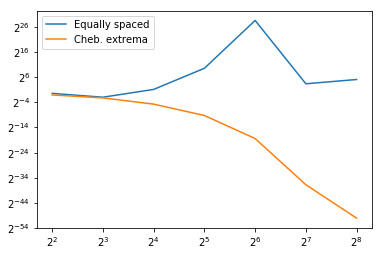

In [8]:
prob4()

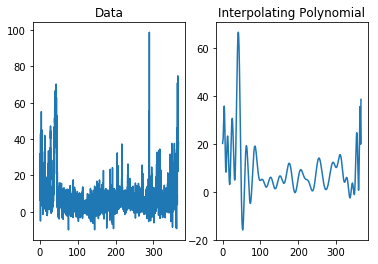

In [9]:
prob6(46)